In [1]:
import pandas as pd
import numpy as np
import os
import fnmatch, re
import glob

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import itertools

In [8]:
def process_individual_semantic(file_path, file_name, column_to_read, rows_to_skip=None):
    participant_file_path = os.path.join(file_path, file_name)
    participant_data = pd.read_csv(participant_file_path, usecols = column_to_read)
    
    participant_data["selected_semantic.response"] = participant_data["selected_semantic.response"].replace([1,2,3,4],["Shape/Orientation", "Color","Material","Lighting"])
    
    cross_tab =  pd.crosstab([participant_data.pair_type, participant_data.layers],
                              participant_data['selected_semantic.response'], 
                               margins = False, normalize = "index")
    
    return participant_data, cross_tab


def process_all_people(file_path):
    files = list(filter(lambda f: os.path.isfile(os.path.join(file_path,f)), os.listdir(file_path)))
    
    data_to_read = ["Trial_num", "image_name", "image_path", "pair_type", "layers", "selected_semantic.response"]
    cross_tab_all = []
    people_data = []
    for person_data in files:
        if fnmatch.fnmatch(person_data, '*.csv'):
            participant_data, cross_tab_person = process_individual_semantic(file_path, person_data, data_to_read)
            cross_tab_np = np.array(cross_tab_person)
            people_data.append(participant_data)
            cross_tab_all.append(cross_tab_np)

    return people_data, cross_tab_all


def compute_iou(response):
    num_people = len(people_data_all)
    iou_matrix = np.empty((num_people,num_people))
    for i in range(num_people):
        for j in range(num_people):
            p1 = people_data_all[i][(people_data_all[i]['selected_semantic.response'] == response)].image_name
            p2 = people_data_all[j][(people_data_all[j]['selected_semantic.response'] == response)].image_name
            p1_as_set = set(p1)
            intersection = p1_as_set.intersection(p2)
            union = p1.append(p2)
            union = set(union)
            union=list(union)
            iou = len(intersection)/len(union)
            iou_matrix[i][j] = iou
          
    
    f, ax = plt.subplots(figsize=(11, 9))
  
    sns.set(font_scale = 0.8)
    
    color_map = sns.mpl_palette("Blues", 5)
    
    mask = np.zeros_like(iou_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    person_id = list(range(num_people))
    sns_plot = sns.heatmap(iou_matrix, mask=mask, annot=True, xticklabels=person_id, yticklabels=person_id, 
                           cbar_kws={'ticks': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]},
                           cmap=color_map,vmax=1, vmin=0,
                           square=True, linewidths=.5)
    
    
def get_all_agree(response):
    all_people = []
    for i in range(len(people_data_all)):
        attribute_response = people_data_all[i][people_data_all[i]['selected_semantic.response'] == response].image_name
        all_people.extend(attribute_response)
    all_people = set(all_people)
        
   
    print(len(all_people))
    
    
def plot_cross_tab(cross_tab):
    OO, OT, TT = np.split(cross_tab, 3, axis = 0) 
    
    x_axis_labels = ["Color", "Lighting", "Material", "Shape"]
    
    y_axis_labels = ["layer0-5", "layer6-8", "layer9-17"]

    fig = plt.figure(figsize=(30, 6))
    plt.subplot(1,3,1) # first heatmap
    sns.set(font_scale=2)
    
    fmt = lambda x,pos: '{:.1%}'.format(x)
    
    g=sns.heatmap(OO, annot=True, cmap= "gray_r", linewidths=1, square=True, fmt='.1%', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    g.set(xlabel='Attribute', ylabel='Layers',
                           title='Opaque-Opaque Pair')
    
    plt.subplot(1,3,2) # second heatmap
    g=sns.heatmap(OT, annot=True, cmap= "gray_r", linewidths=1, square=True, fmt='.1%', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    g.set(xlabel='Attribute', ylabel='Layers',
                           title='Opaque-Translucent Pair')
    
    
    plt.subplot(1,3,3) # third heatmap
    g=sns.heatmap(TT, annot=True, cmap= "gray_r", linewidths=2, square=True, fmt='.1%',  xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    g.set(xlabel='Attribute', ylabel='Layers',
                           title='Translucent-Translucent Pair')
    plt.show()



In [6]:
## Read the data

semantic_file_path = "data/semantic-good-data"

people_data_all, cross_tab_all = process_all_people(semantic_file_path)

# Plot scene attribute evaluation heatmaps

Num of participant: 20


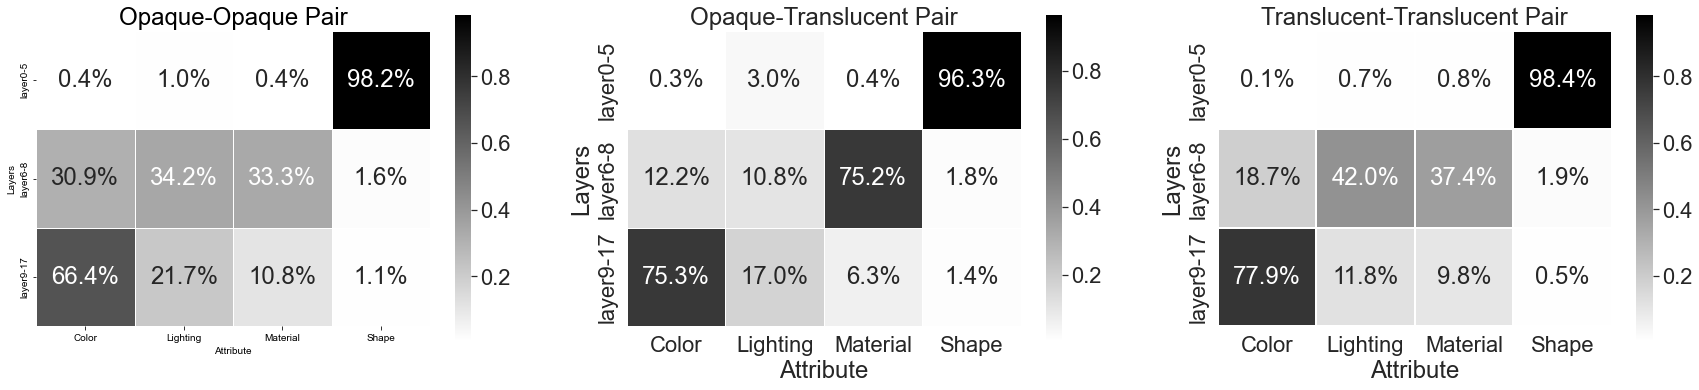

In [9]:
   
print("Num of participant:",len(cross_tab_all))
mean_cross_tab = sum(cross_tab_all)/len(cross_tab_all)
mean_cross_tab
    
plot_cross_tab(mean_cross_tab)    

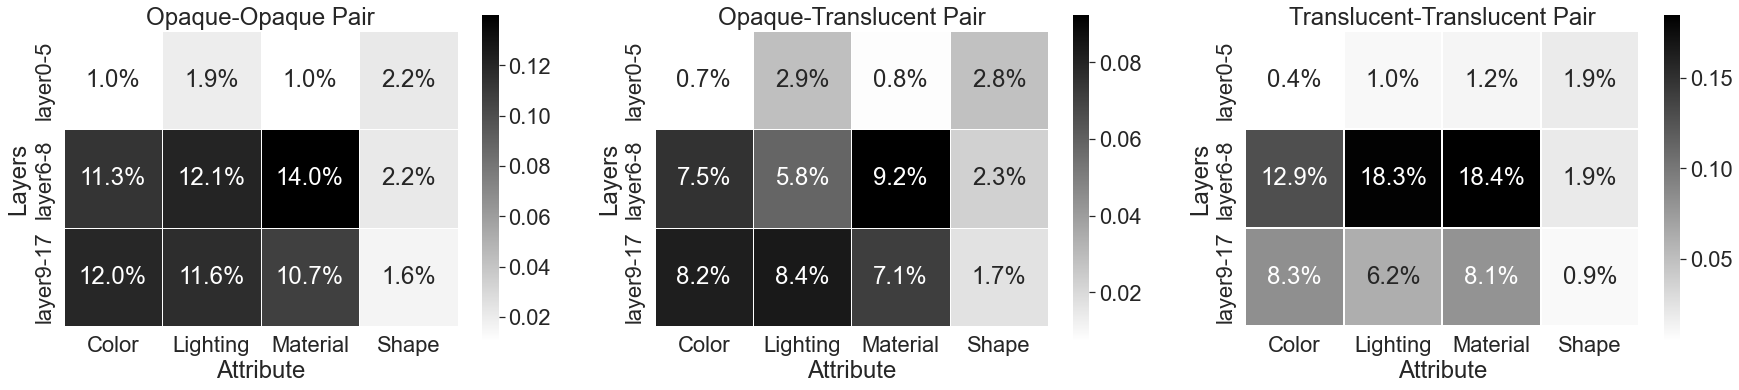

In [11]:
# Show scene attribute evaluation heatmaps (standard deviations)
std_tab = np.std(np.array(cross_tab_all), axis = 0)
plot_cross_tab(std_tab)